# Part 1: Dealing with raw data

In [ ]:
install.packages("car")
install.packages("leaps")
install.packages("faraway")
install.packages("glmnet")

In [4]:
install.packages("glmnet")

also installing the dependencies 'codetools', 'iterators', 'foreach'



package 'codetools' successfully unpacked and MD5 sums checked
package 'iterators' successfully unpacked and MD5 sums checked
package 'foreach' successfully unpacked and MD5 sums checked
package 'glmnet' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Mark Wei\AppData\Local\Temp\Rtmp23Zw9d\downloaded_packages


In [1]:
library(car)
library(leaps)
library(faraway)
library(glmnet)

Loading required package: carData
Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

Attaching package: 'faraway'

The following objects are masked from 'package:car':

    logit, vif

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-18



In [2]:
setwd("C:/Users/Mark Wei/Desktop/628/Project 2")

#### Read in the raw data and do data cleaning (detect points which bodyfat does not have a linear relationship of 1 / density), then get rid of the variable: "density":

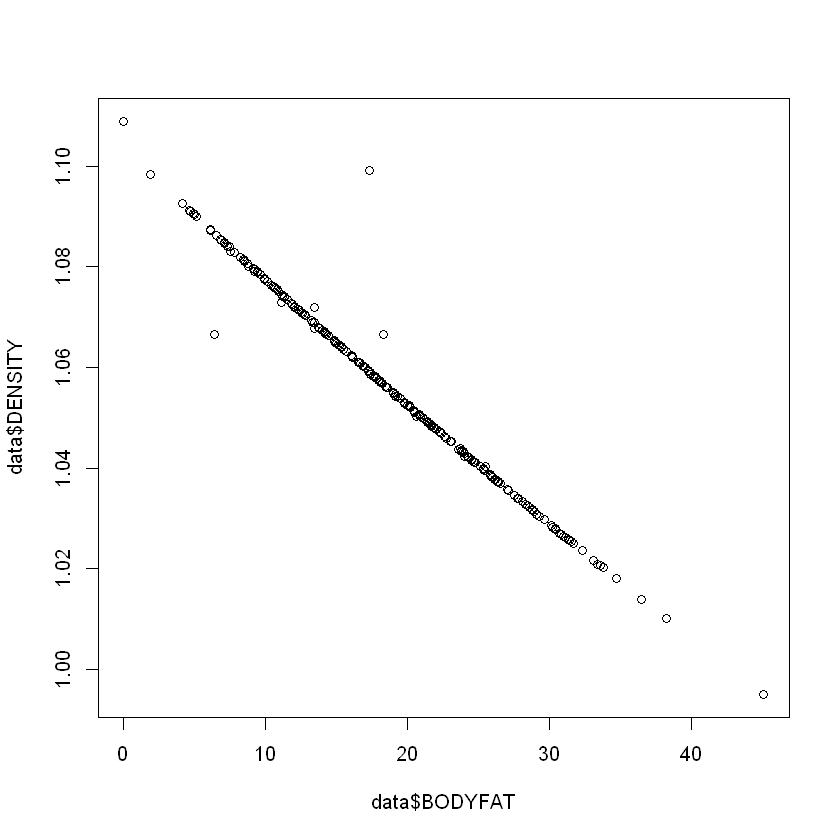

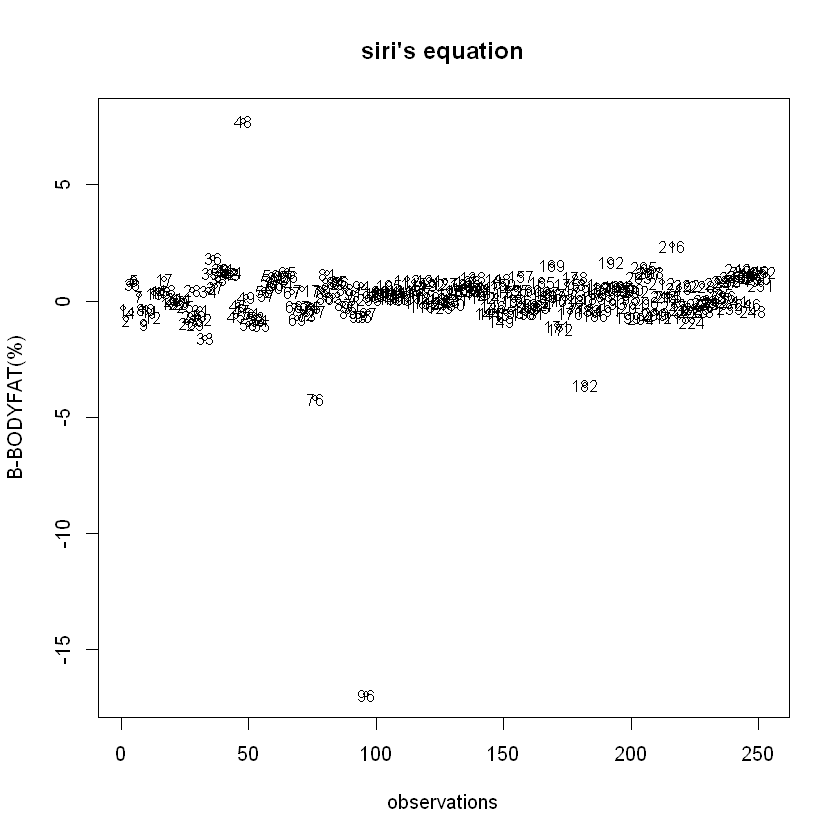

In [3]:
data = read.csv("BodyFat.csv", row.names = 1)
# data cleaning 
# detect points which bodyfat does not have a linear relationship of 1 / density
plot(data$BODYFAT,data$DENSITY)
B = 495*(1/data$DENSITY)-450
plot(B-data$BODYFAT,xlab = 'observations', ylab = 'B-BODYFAT(%)', main = "siri's equation",type="p",cex=0.7)
text(1:length(data[,1]), B-data$BODYFAT, 1:length(data[,1]),cex=0.8)
data_new = data[, -2]

#### Check the cook's distance one by one:

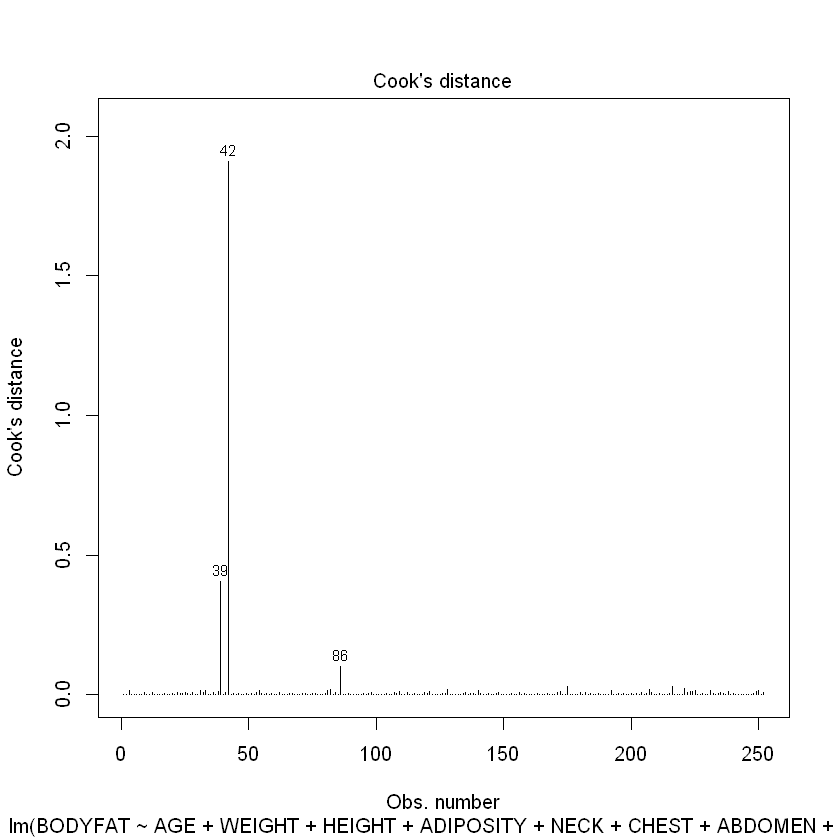

In [4]:
model1<- lm(BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + CHEST + ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST,
            data = data)
plot(model1, which = 4)

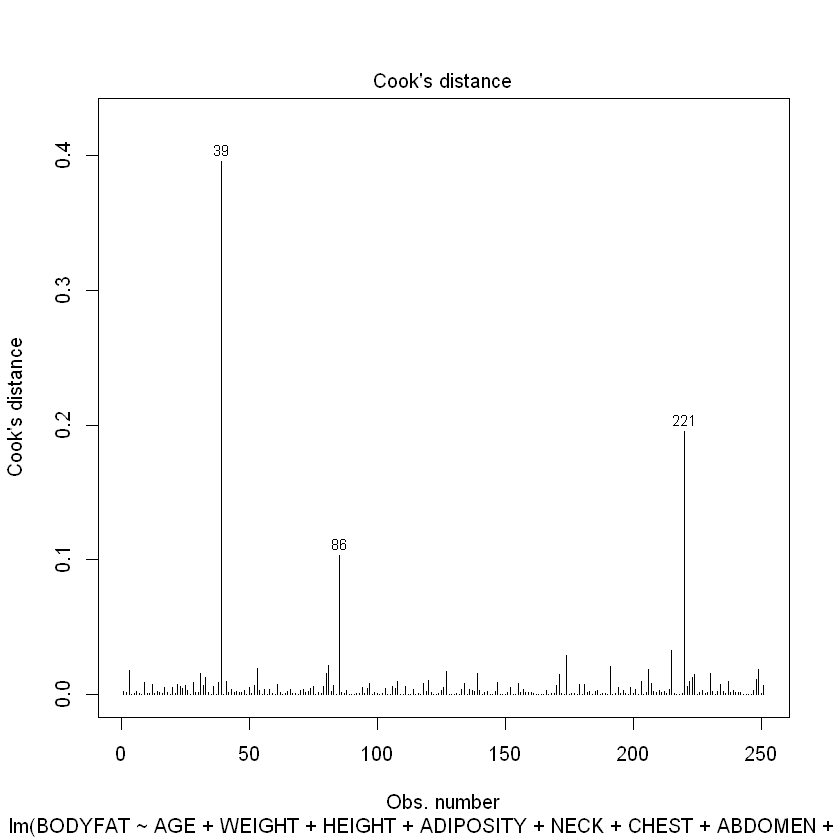

In [13]:
model2<- lm(BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + CHEST + ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST,
            data = data[-42,])
plot(model2, which = 4)

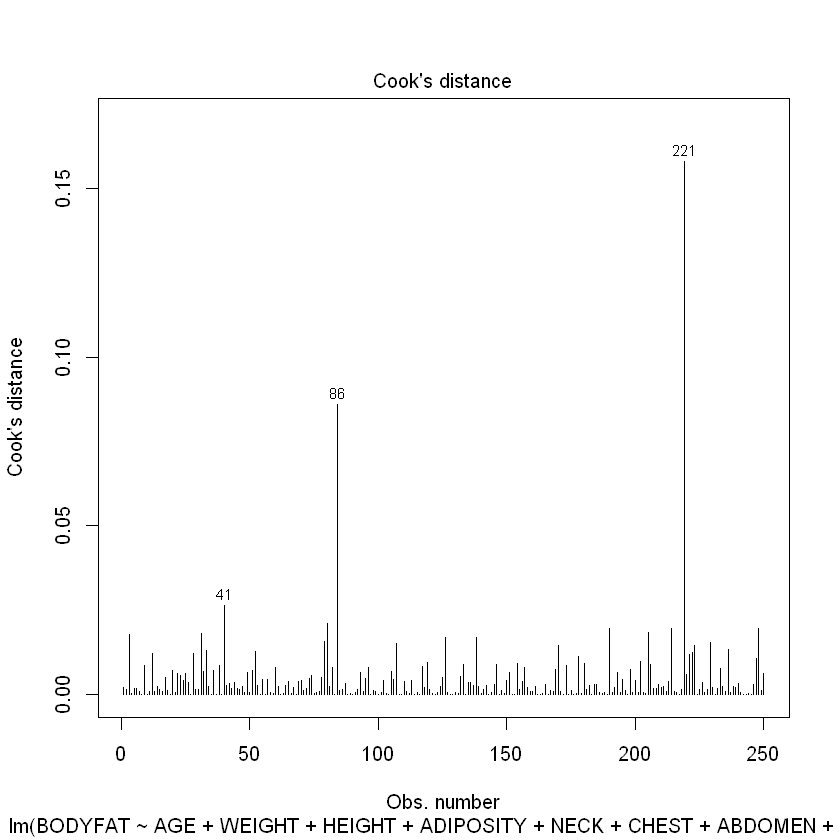

In [14]:
model3<- lm(BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + CHEST + ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST,
            data = data[-c(39,42),])
plot(model3, which = 4)

#### Then delete possible outliers. No.39 has too large weight; No.42 is way too short; 
#### No.8,No.76,No.96 does not match the relationship between bodyfat and density;
#### No.182 has bodyfat 0, it is a mistake.
#### We remove them and scale the data.

In [5]:
data[c(39, 42, 48, 96, 76, 182),]
data_clean = data_new[c(-39, -42, -48, -96, -76, -182), ]
data_clean<-data.frame(scale(data_clean))
write.csv(data_clean,"bodyfat_clean.csv",row.names = F)

,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
39,33.8,1.0202,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
42,31.7,1.0250,44,205.00,29.50,29.9,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4
48,6.4,1.0665,39,148.50,71.25,20.6,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8,17.9
96,17.3,1.0991,53,224.50,77.75,26.1,41.1,113.2,99.2,107.5,61.7,42.3,23.2,32.9,30.8,20.4
76,18.3,1.0666,61,148.25,67.50,22.9,36.0,91.6,81.8,94.8,54.5,37.0,21.4,29.3,27.0,18.3
182,0.0,1.1089,40,118.50,68.00,18.1,33.8,79.3,69.4,85.0,47.2,33.5,20.2,27.7,24.6,16.5


#### We check new data's Cook's distance again and find nothing weird. The possible outlier No.227 might be caused by randomness. Also the outlierTest gives same conclusion.

,BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
227,-0.5341887,0.801263,-0.3326625,-0.7894715,0.0663065,-0.3391391,0.1149318,-0.1330352,-0.4113888,-0.5625032,-0.02107772,-0.3013611,0.3912692,0.3050366,0.6421832


No Studentized residuals with Bonferroni p < 0.05
Largest |rstudent|:
     rstudent unadjusted p-value Bonferroni p
224 -2.592132           0.010149           NA

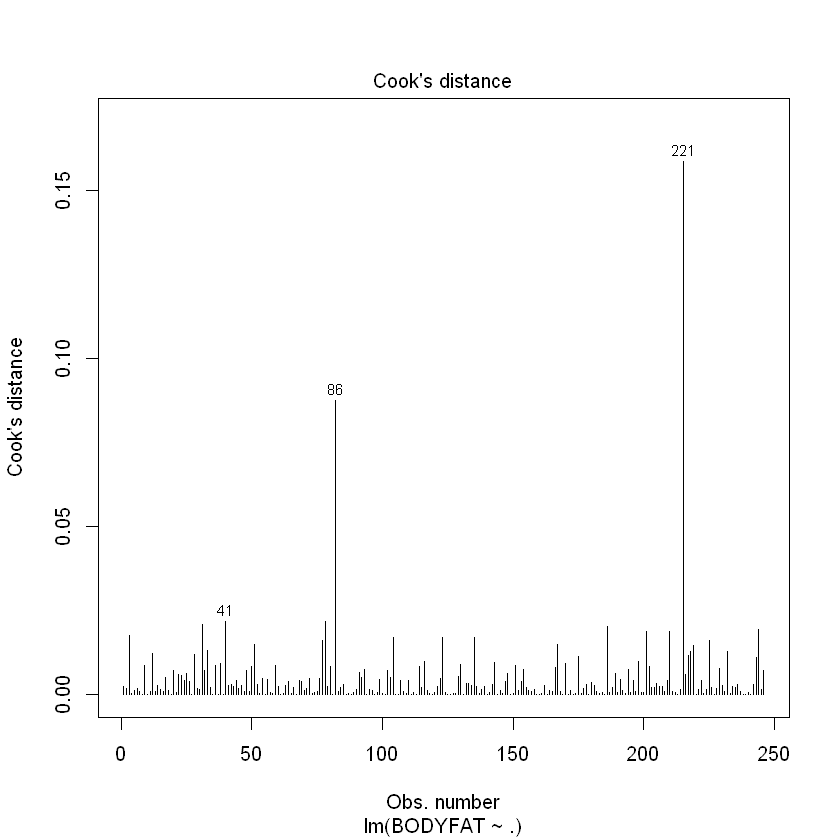

In [6]:
model = lm(BODYFAT ~ ., data = data_clean)
plot(model, which = 4)
data_clean[221,]

# outlier test
outlierTest(model)

# Part 2: Model selection

#### The methods we use are: AIC, BIC, Mallow's Cp, Adjusted-R^2 and lasso.

In [7]:
full = lm(BODYFAT ~ ., data = data_clean)
base = lm(BODYFAT ~ 1, data = data_clean)

#### 1. AIC (Backward, forward and both sides)

In [8]:
model_AIC_b = step(full, direction = "backward", trace = 0)
print(model_AIC_b)
summary(model_AIC_b)

model_AIC_f = step(base, direction = "forward", trace = 0,scope = list(lower = base, upper = full))
print(model_AIC_f)

model_AIC_t = step(base, direction = "both", trace = 0, scope = list(lower = base, upper = full))
print(model_AIC_t)


Call:
lm(formula = BODYFAT ~ AGE + ADIPOSITY + NECK + CHEST + ABDOMEN + 
    HIP + BICEPS + WRIST, data = data_clean)

Coefficients:
(Intercept)          AGE    ADIPOSITY         NECK        CHEST      ABDOMEN  
  7.443e-16    8.637e-02    2.449e-01   -1.095e-01   -2.244e-01    1.075e+00  
        HIP       BICEPS        WRIST  
 -1.780e-01    8.687e-02   -1.992e-01  




Call:
lm(formula = BODYFAT ~ AGE + ADIPOSITY + NECK + CHEST + ABDOMEN + 
    HIP + BICEPS + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.26211 -0.36879 -0.04845  0.38595  1.22322 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.443e-16  3.281e-02   0.000 1.000000    
AGE          8.637e-02  4.301e-02   2.008 0.045774 *  
ADIPOSITY    2.449e-01  1.003e-01   2.443 0.015300 *  
NECK        -1.095e-01  6.063e-02  -1.806 0.072184 .  
CHEST       -2.244e-01  9.459e-02  -2.372 0.018486 *  
ABDOMEN      1.075e+00  1.094e-01   9.825  < 2e-16 ***
HIP         -1.780e-01  8.490e-02  -2.096 0.037110 *  
BICEPS       8.687e-02  5.443e-02   1.596 0.111834    
WRIST       -1.992e-01  5.243e-02  -3.799 0.000185 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5146 on 237 degrees of freedom
Multiple R-squared:  0.7438,	Adjusted R-squared:  0.7352 
F-statistic: 86.02 on 8 and 


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT        WRIST       BICEPS  
  7.716e-16    1.187e+00   -3.817e-01   -1.659e-01    1.028e-01  


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT        WRIST       BICEPS  
  7.278e-16    1.187e+00   -3.817e-01   -1.659e-01    1.028e-01  



#### 2. BIC (Backward, forward and both sides)

In [9]:
n = dim(data)[1]
model_BIC_b = step(full, direction = "backward", trace = 0, k = log(n))
print(model_BIC_b)
summary(model_BIC_b)

model_BIC_f = step(base, direction = "forward", trace = 0, scope = list(lower = base, upper = full), k = log(n))
print(model_BIC_f )

model_BIC_t = step(full, direction = "both", trace = 0, k = log(n))
print(model_BIC_t)
summary(model_BIC_t)


Call:
lm(formula = BODYFAT ~ AGE + ABDOMEN + WRIST, data = data_clean)

Coefficients:
(Intercept)          AGE      ABDOMEN        WRIST  
  6.146e-16    1.154e-01    9.482e-01   -2.587e-01  




Call:
lm(formula = BODYFAT ~ AGE + ABDOMEN + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.22877 -0.36001 -0.06389  0.39959  1.28253 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.146e-16  3.354e-02   0.000  1.00000    
AGE          1.154e-01  3.479e-02   3.316  0.00105 ** 
ABDOMEN      9.482e-01  4.244e-02  22.342  < 2e-16 ***
WRIST       -2.587e-01  4.210e-02  -6.146 3.25e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.526 on 242 degrees of freedom
Multiple R-squared:  0.7267,	Adjusted R-squared:  0.7233 
F-statistic: 214.5 on 3 and 242 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT        WRIST  
  7.737e-16    1.173e+00   -2.967e-01   -1.556e-01  


Call:
lm(formula = BODYFAT ~ ABDOMEN + WRIST + HEIGHT, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN        WRIST       HEIGHT  
  2.984e-16    9.591e-01   -1.918e-01   -1.293e-01  




Call:
lm(formula = BODYFAT ~ ABDOMEN + WRIST + HEIGHT, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.19183 -0.38444 -0.03496  0.37947  1.19786 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.984e-16  3.342e-02   0.000  1.00000    
ABDOMEN      9.591e-01  4.191e-02  22.884  < 2e-16 ***
WRIST       -1.918e-01  4.459e-02  -4.301 2.47e-05 ***
HEIGHT      -1.293e-01  3.628e-02  -3.564  0.00044 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5242 on 242 degrees of freedom
Multiple R-squared:  0.7285,	Adjusted R-squared:  0.7252 
F-statistic: 216.5 on 3 and 242 DF,  p-value: < 2.2e-16


#### 3. Mallow's cp

[1] "AGE"     "HEIGHT"  "CHEST"   "ABDOMEN" "BICEPS"  "WRIST"  



Call:
lm(formula = cp_model, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.26853 -0.37613 -0.02628  0.39564  1.09015 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.513e-16  3.294e-02   0.000  1.00000    
AGE          8.909e-02  3.851e-02   2.313  0.02156 *  
HEIGHT      -1.043e-01  3.850e-02  -2.709  0.00725 ** 
CHEST       -1.741e-01  8.572e-02  -2.031  0.04340 *  
ABDOMEN      1.053e+00  8.070e-02  13.045  < 2e-16 ***
BICEPS       8.001e-02  5.142e-02   1.556  0.12102    
WRIST       -2.148e-01  4.925e-02  -4.362 1.92e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5167 on 239 degrees of freedom
Multiple R-squared:  0.7396,	Adjusted R-squared:  0.733 
F-statistic: 113.1 on 6 and 239 DF,  p-value: < 2.2e-16


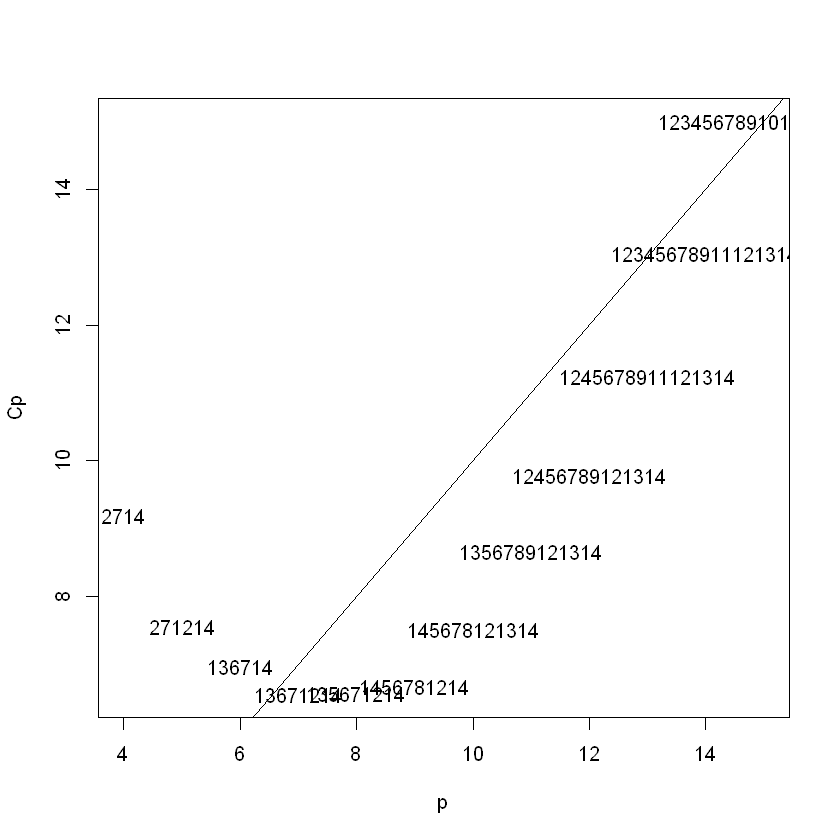

In [10]:
X = data_clean[, -1]
Y = data_clean$BODYFAT
g = leaps(X, Y, nbest = 1)
Cpplot(g)
print(colnames(data_clean)[c(1, 3, 6, 7, 12, 14) + 1])
cp_model = BODYFAT ~ AGE + HEIGHT + CHEST + ABDOMEN +  BICEPS + WRIST
cp_lm = lm(cp_model, data=data_clean)
summary(cp_lm)

#### 4. Adjusted R square

1     2     3     4     5     6     7     8     9     A     B     C     D 
 TRUE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE  TRUE  TRUE 
    E 
 TRUE

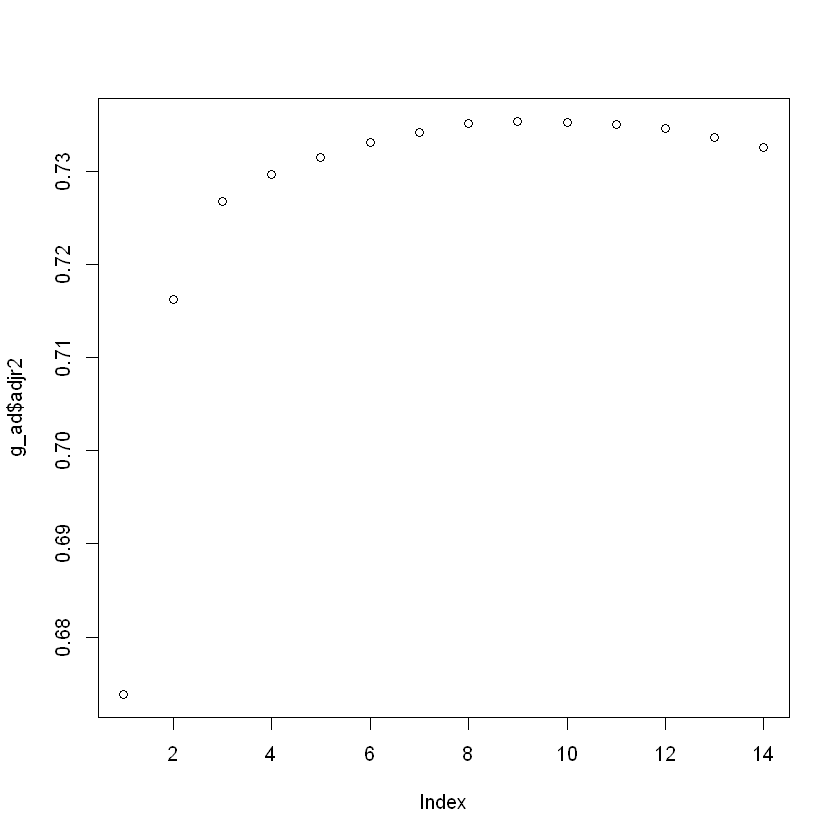

In [11]:
g_ad = leaps(X, Y, nbest = 1,method="adjr2")
plot(g_ad$adjr2)
(g_ad$which)[which(g_ad$adjr2==max(g_ad$adjr2)),]

#### 5. Lasso


Call:  glmnet(x = as.matrix(data_clean[, 2:15]), y = data_clean$BODYFAT,      family = "gaussian", alpha = 1, nlambda = 50, standardize = T) 

      Df   %Dev    Lambda
 [1,]  0 0.0000 0.8200000
 [2,]  1 0.2116 0.6795000
 [3,]  1 0.3568 0.5631000
 [4,]  1 0.4566 0.4666000
 [5,]  1 0.5251 0.3866000
 [6,]  1 0.5721 0.3204000
 [7,]  1 0.6044 0.2655000
 [8,]  1 0.6266 0.2200000
 [9,]  1 0.6418 0.1823000
[10,]  2 0.6523 0.1511000
[11,]  2 0.6697 0.1252000
[12,]  2 0.6816 0.1037000
[13,]  3 0.6901 0.0859500
[14,]  4 0.7037 0.0712200
[15,]  4 0.7131 0.0590100
[16,]  4 0.7196 0.0489000
[17,]  4 0.7241 0.0405200
[18,]  4 0.7271 0.0335800
[19,]  5 0.7296 0.0278200
[20,]  5 0.7316 0.0230600
[21,]  7 0.7339 0.0191100
[22,]  7 0.7358 0.0158300
[23,]  9 0.7371 0.0131200
[24,] 10 0.7392 0.0108700
[25,] 11 0.7411 0.0090080
[26,] 11 0.7429 0.0074640
[27,] 11 0.7441 0.0061850
[28,] 11 0.7449 0.0051250
[29,] 11 0.7454 0.0042470
[30,] 12 0.7458 0.0035190
[31,] 13 0.7462 0.0029160
[32,] 13 0.7464 0.002417

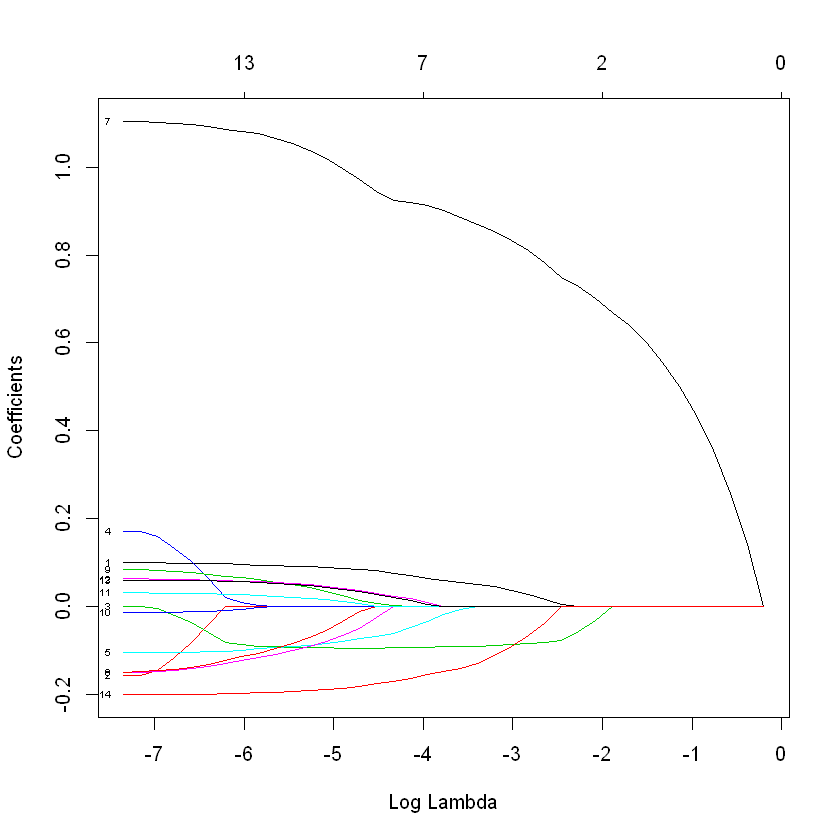

15 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  2.338902e-16
AGE          2.625582e-02
WEIGHT       .           
HEIGHT      -8.420940e-02
ADIPOSITY    .           
NECK         .           
CHEST        .           
ABDOMEN      8.065582e-01
HIP          .           
THIGH        .           
KNEE         .           
ANKLE        .           
BICEPS       .           
FOREARM      .           
WRIST       -6.240514e-02


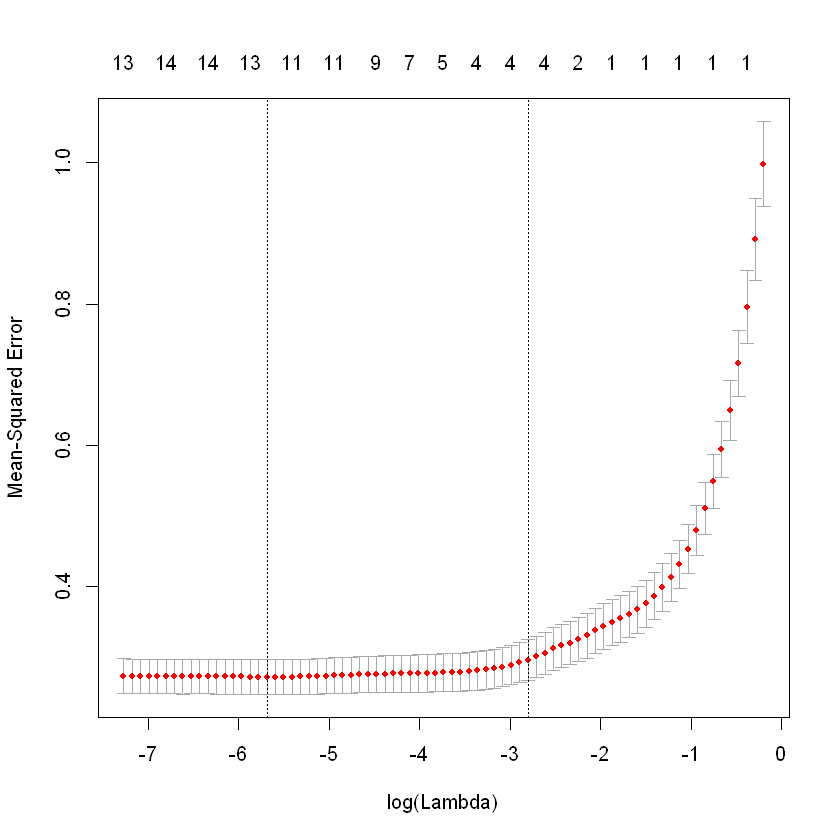

In [12]:
model_l <- glmnet(as.matrix(data_clean[,2:15]), data_clean$BODYFAT, family = "gaussian", nlambda = 50, alpha = 1,standardize = T)
print(model_l)
plot(model_l, xvar = "lambda", label = T)
cvfit <- cv.glmnet(as.matrix(data_clean[,2:15]), data_clean$BODYFAT, family = "gaussian", type.measure = "mse", nfolds = 10,alpha = 1)
plot(cvfit)
print(coef(cvfit, s = "lambda.1se" ))
model_lasso<- BODYFAT ~ AGE + HEIGHT  + ABDOMEN +  WRIST
model_l<-lm(BODYFAT ~ AGE + HEIGHT  + ABDOMEN +  WRIST,data=data_clean)

# Part3: Other analysis

#### Check the possible multicolinearity betweeen abdomen and wrist,weight

In [ ]:
cor(data_clean$WRIST,data_clean$ABDOMEN)
cor(data_clean$WEIGHT,data_clean$ABDOMEN)
cor(data_clean$WRIST,data_clean$WEIGHT)
vif(model_BIC_f)